# Мастерская Лента

## Описание задачи

Построить модель прогноза спроса на 14 дней для товаров собственного производства на основе мастер данных и данных продаж с учетом разных признаков. Гранулярность ТК-SKU-День.

Прогноз позволит повысить доступность и продажи в ТК, без повышения списаний и повышение маржинальности. При изготовлении товаров СП сотрудники будут ориентироваться не на экспертный подход, а на ML прогноз спроса, в соответствии с которым будут изготавливать продукцию и планировать заказы сырья.

## Знакомство с данными

Бизнес-заказчиком передано 3 датасета: `pr_df.csv`, `sales_df_train.csv`, `sf_df.csv`:

1. Датасет `sales_df_train.csv` содержит данные по продажам за скользящий год для обучения.

    Столбцы:

    `st_id` – захэшированное id магазина;

    `pr_sku_id` – захэшированное id товара;

    `date` – дата;

    `pr_sales_type_id` – флаг наличия промо;

    `pr_sales_in_units` – число проданных товаров всего (промо и без промо);

    `pr_promo_sales_in_units` – число проданных товаров с признаком промо; 

    `pr_sales_in_rub` – продажи всего (промо и без промо) в РУБ; 

    `pr_promo_sales_in_rub` – продажи с признаком промо в РУБ;

2. Датасет `pr_df.csv` содержит данные по товарной иерархии. Иерархия представлена последовательностью от большего к меньшему `pr_group_id` - `pr_cat_id` - `pr_subcat_id` - `pr_sku_id`.

    Столбцы:

    `pr_group_id` – захэшированная группа товара;

    `pr_cat_id` – захэшированная категория товара;

    `pr_subcat_id` – захэшированная подкатегория товара;

    `pr_sku_id` – захэшированное id товара;

    `pr_uom_id` (маркер, обозначающий продаётся товар на вес или в ШТ).

3. Датасет `sf_df.csv` содержит данные по магазинам.

    Столбцы:

    `st_id` – захэшированное id магазина;

    `st_city_id` – захэшированное id города;

    `st_division_code id` – захэшированное id дивизиона; 
    
    `st_type_format_id` – id формата магазина;

    `st_type_loc_id` – id тип локации/окружения магазина; 
    
    `st_type_size_id` – id типа размера магазина;

    `st_is_active` – флаг активного магазина на данный момент.

Импортируем необходимые библиотеки:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Прочитаем представленные данные и посмотрим общую информацию о них:

In [2]:
pr_df = pd.read_csv('pr_df.csv')

In [3]:
sales_df_train = pd.read_csv('sales_df_train.csv')

In [4]:
sf_df = pd.read_csv('st_df.csv')

In [5]:
def read_data(data):
    print(data.info())
    print(data.head())
    print(data.describe())

In [6]:
read_data(pr_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2050 entries, 0 to 2049
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   pr_sku_id     2050 non-null   object
 1   pr_group_id   2050 non-null   object
 2   pr_cat_id     2050 non-null   object
 3   pr_subcat_id  2050 non-null   object
 4   pr_uom_id     2050 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 80.2+ KB
None
                          pr_sku_id                       pr_group_id  \
0  fd064933250b0bfe4f926b867b0a5ec8  c74d97b01eae257e44aa9d5bade97baf   
1  71c9661741caf40a92a32d1cc8206c04  c74d97b01eae257e44aa9d5bade97baf   
2  00b72c2f01a1512cbb1d3f33319bac93  c74d97b01eae257e44aa9d5bade97baf   
3  9bc40cd2fe4f188f402bb41548c5e15c  c74d97b01eae257e44aa9d5bade97baf   
4  3a74a370c8eb032acb11ad9119242b8f  c74d97b01eae257e44aa9d5bade97baf   

                          pr_cat_id                      pr_subcat_id  \
0  1bc0249a6412ef49b07fe6f62e6dc

Датасет указывает на иерархию товаров, пропусков в данных нет. Оставляем эти данные без изменений.

In [7]:
read_data(sales_df_train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883015 entries, 0 to 883014
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   st_id                    883015 non-null  object 
 1   pr_sku_id                883015 non-null  object 
 2   date                     883015 non-null  object 
 3   pr_sales_type_id         883015 non-null  int64  
 4   pr_sales_in_units        883015 non-null  float64
 5   pr_promo_sales_in_units  883015 non-null  float64
 6   pr_sales_in_rub          883015 non-null  float64
 7   pr_promo_sales_in_rub    883015 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 53.9+ MB
None
                              st_id                         pr_sku_id  \
0  c81e728d9d4c2f636f067f89cc14862c  c7b711619071c92bef604c7ad68380dd   
1  42a0e188f5033bc65bf8d78622277c4e  68f441429e73dbd33b81f95da31576e9   
2  1ecfb463472ec9115b10c292ef8bc986  22988026fe85fde6

Сразу вызывают сомнения минусовые значения в столбцах количества и суммы продаж. Либо это возвраты, либо какие то ошибочные данные, в любом случае мы их убираем из наших данных. Аналогично поступим и с нулевыми значениями продаж, ведь нам нужно предугадать спрос, следовательно, нет смысла отталкиваться от нулевых значений.

Так как из описания данных ясно, что  `pr_sales_in_units` – число проданных товаров всего (промо и без промо), `pr_promo_sales_in_units` – число проданных товаров с признаком промо, `pr_sales_in_rub` – продажи всего (промо и без промо) в РУБ, а `pr_promo_sales_in_rub` – продажи с признаком промо в РУБ, то столбцы `pr_promo_sales_in_units` и `pr_promo_sales_in_rub` можно исключить.

In [8]:
sales_df_train = sales_df_train.drop(columns = ['pr_promo_sales_in_units', 'pr_promo_sales_in_rub'], axis = 1) 

In [9]:
read_data(sf_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   st_id              12 non-null     object
 1   st_city_id         12 non-null     object
 2   st_division_code   12 non-null     object
 3   st_type_format_id  12 non-null     int64 
 4   st_type_loc_id     12 non-null     int64 
 5   st_type_size_id    12 non-null     int64 
 6   st_is_active       12 non-null     int64 
dtypes: int64(4), object(3)
memory usage: 800.0+ bytes
None
                              st_id                        st_city_id  \
0  1aa057313c28fa4a40c5bc084b11d276  1587965fb4d4b5afe8428a4a024feb0d   
1  bd470ca955d9497bbcb808e59952fffc  955d864a62659945cc9434898e275deb   
2  6364d3f0f495b6ab9dcf8d3b5c6e0b01  b8b4b727d6f5d1b61fff7be687f7970f   
3  1ecfb463472ec9115b10c292ef8bc986  908c9a564a86426585b29f5335b619bc   
4  16a5cdae362b8d27a1d8f8c7b78b4330  c1f75cc0f7fe2

В данном датасете у нас хранится информация о торговых комплексах (ТК). Интересный столбец со статусом магазина `st_is_active`. То есть наши данные хранят информацию о уже неактивных магазинах, их мы тоже смело можем исключить. Они в нашей модели будут лишними, ведь предсказание будет зависеть от работы ТК.

### Объединение данных

Для начала объединим наши данные в один датасет:

In [10]:
data = sales_df_train.merge(sf_df, on = 'st_id').merge(pr_df, on = 'pr_sku_id') 

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883015 entries, 0 to 883014
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   st_id              883015 non-null  object 
 1   pr_sku_id          883015 non-null  object 
 2   date               883015 non-null  object 
 3   pr_sales_type_id   883015 non-null  int64  
 4   pr_sales_in_units  883015 non-null  float64
 5   pr_sales_in_rub    883015 non-null  float64
 6   st_city_id         883015 non-null  object 
 7   st_division_code   883015 non-null  object 
 8   st_type_format_id  883015 non-null  int64  
 9   st_type_loc_id     883015 non-null  int64  
 10  st_type_size_id    883015 non-null  int64  
 11  st_is_active       883015 non-null  int64  
 12  pr_group_id        883015 non-null  object 
 13  pr_cat_id          883015 non-null  object 
 14  pr_subcat_id       883015 non-null  object 
 15  pr_uom_id          883015 non-null  int64  
dtypes:

In [12]:
data.head()

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_sales_in_rub,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id
0,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-10-20,1,5.0,825.0,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,1,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,d29b5ce9c2883f0b7e90f79071a2ca82,1
1,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2023-02-02,1,1.0,107.0,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,1,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,d29b5ce9c2883f0b7e90f79071a2ca82,1
2,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-10-09,1,1.0,167.0,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,1,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,d29b5ce9c2883f0b7e90f79071a2ca82,1
3,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2023-06-22,0,0.0,79.0,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,1,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,d29b5ce9c2883f0b7e90f79071a2ca82,1
4,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2023-06-30,1,25.0,3766.0,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,1,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,d29b5ce9c2883f0b7e90f79071a2ca82,1


Теперь посмотрим, как распределяются продажи по магазинам:

### Удаление продаж с минусовыми и нулевыми значениями и удаление неактивных ТК

В данных содержится информация о двух ТК, которые уже неактивны, информацию о данных ТК мы и удалим.

In [13]:
data = data[(data['pr_sales_in_units'] > 0)& (data['pr_sales_in_rub'] > 0) & (data['st_is_active'] != 0)]

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 814881 entries, 0 to 883014
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   st_id              814881 non-null  object 
 1   pr_sku_id          814881 non-null  object 
 2   date               814881 non-null  object 
 3   pr_sales_type_id   814881 non-null  int64  
 4   pr_sales_in_units  814881 non-null  float64
 5   pr_sales_in_rub    814881 non-null  float64
 6   st_city_id         814881 non-null  object 
 7   st_division_code   814881 non-null  object 
 8   st_type_format_id  814881 non-null  int64  
 9   st_type_loc_id     814881 non-null  int64  
 10  st_type_size_id    814881 non-null  int64  
 11  st_is_active       814881 non-null  int64  
 12  pr_group_id        814881 non-null  object 
 13  pr_cat_id          814881 non-null  object 
 14  pr_subcat_id       814881 non-null  object 
 15  pr_uom_id          814881 non-null  int64  
dtypes: floa

In [15]:
data.describe()

,pr_sales_type_id,pr_sales_in_units,pr_sales_in_rub,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active,pr_uom_id
count,814881.000000,814881.000000,814881.000000,814881.000000,814881.000000,814881.000000,814881.0,814881.000000
mean,0.400998,5.452354,640.105715,1.099091,1.204884,11.501705,1.0,7.204567
std,0.490101,13.869236,1634.419367,0.417325,0.437268,4.601198,0.0,7.795928
min,0.000000,1.000000,1.000000,1.000000,1.000000,8.000000,1.0,1.000000
25%,0.000000,1.000000,116.000000,1.000000,1.000000,8.000000,1.0,1.000000
50%,0.000000,2.000000,251.000000,1.000000,1.000000,12.000000,1.0,1.000000
75%,1.000000,5.000000,588.000000,1.000000,1.000000,12.000000,1.0,17.000000
max,1.000000,2348.000000,183265.000000,4.000000,3.000000,28.000000,1.0,17.000000


Изначальный набор данных содержал 883015 строк о продажах товаров собственного производства. После начальной обработки данных осталось 814881 строк, т.е. мы очистили 7,7% данных.

Так как столбец `st_is_active` содержал только 2 значения - это 0 и 1, а мы исключили из данных позиции с неактивными ТК, то данный столбец можно исключить.

In [16]:
data = data.drop(columns='st_is_active', axis=1)

Теперь посмотрим, есть в наших данных дубликаты:

In [17]:
data.duplicated().sum()

0

Дубликатов нет, можно работать дальше

In [18]:
data.head()

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_sales_in_rub,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id
0,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-10-20,1,5.0,825.0,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,d29b5ce9c2883f0b7e90f79071a2ca82,1
1,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2023-02-02,1,1.0,107.0,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,d29b5ce9c2883f0b7e90f79071a2ca82,1
2,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-10-09,1,1.0,167.0,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,d29b5ce9c2883f0b7e90f79071a2ca82,1
4,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2023-06-30,1,25.0,3766.0,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,d29b5ce9c2883f0b7e90f79071a2ca82,1
5,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-12-29,0,49.0,9143.0,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,d29b5ce9c2883f0b7e90f79071a2ca82,1


Посмотрим на объемы продаж по ТК:

In [19]:
data.groupby(['st_id'])['pr_sales_in_units'].sum()

st_id
084a8a9aa8cced9175bd07bc44998e75        49.0
16a5cdae362b8d27a1d8f8c7b78b4330    872059.0
1ecfb463472ec9115b10c292ef8bc986    129101.0
42a0e188f5033bc65bf8d78622277c4e    725003.0
53e19f3dbb211f20b20b45668303c1b6     19199.0
6364d3f0f495b6ab9dcf8d3b5c6e0b01    529375.0
bd470ca955d9497bbcb808e59952fffc      5112.0
c81e728d9d4c2f636f067f89cc14862c    958456.0
f7e6c85504ce6e82442c770f7c8606f0    673313.0
fa7cdfad1a5aaf8370ebeda47a1ff1c3    531353.0
Name: pr_sales_in_units, dtype: float64

Получается в наших данных большинство ТК имеют продаж за год более 120 тыс. позиций и только 3 ТК имеют очень малые показатели, это ТК под ключом:
- 084a8a9aa8cced9175bd07bc44998e75 (причем этот имеет всего 49 продаж за год).
- 53e19f3dbb211f20b20b45668303c1b6;
- bd470ca955d9497bbcb808e59952fffc.

Я бы не хотел прощаться с данными работающих ТК, посмотрим на них подробнее:

In [20]:
data[(data['st_id'] == '084a8a9aa8cced9175bd07bc44998e75')]

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_sales_in_rub,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id
548746,084a8a9aa8cced9175bd07bc44998e75,c4a665596d4f67cecb7542c9fad407ee,2023-05-06,1,3.0,405.0,3202111cf90e7c816a472aaceb72b0df,32586311f16876abf92901085bd87b99,4,3,19,c20ad4d76fe97759aa27a0c99bff6710,fb2fcd534b0ff3bbed73cc51df620323,45551f4c29881972ae5ed3666a5b1b8b,1
548747,084a8a9aa8cced9175bd07bc44998e75,c4a665596d4f67cecb7542c9fad407ee,2023-05-01,0,2.0,287.0,3202111cf90e7c816a472aaceb72b0df,32586311f16876abf92901085bd87b99,4,3,19,c20ad4d76fe97759aa27a0c99bff6710,fb2fcd534b0ff3bbed73cc51df620323,45551f4c29881972ae5ed3666a5b1b8b,1
882979,084a8a9aa8cced9175bd07bc44998e75,0376a60d9a7ce7965beddc4815588697,2023-06-05,0,1.0,146.0,3202111cf90e7c816a472aaceb72b0df,32586311f16876abf92901085bd87b99,4,3,19,c74d97b01eae257e44aa9d5bade97baf,a368b0de8b91cfb3f91892fbf1ebd4b2,8feef08314d477a5b68ba18a6d35819d,17
882980,084a8a9aa8cced9175bd07bc44998e75,0376a60d9a7ce7965beddc4815588697,2023-04-29,0,1.0,146.0,3202111cf90e7c816a472aaceb72b0df,32586311f16876abf92901085bd87b99,4,3,19,c74d97b01eae257e44aa9d5bade97baf,a368b0de8b91cfb3f91892fbf1ebd4b2,8feef08314d477a5b68ba18a6d35819d,17
882981,084a8a9aa8cced9175bd07bc44998e75,0376a60d9a7ce7965beddc4815588697,2023-05-24,0,1.0,146.0,3202111cf90e7c816a472aaceb72b0df,32586311f16876abf92901085bd87b99,4,3,19,c74d97b01eae257e44aa9d5bade97baf,a368b0de8b91cfb3f91892fbf1ebd4b2,8feef08314d477a5b68ba18a6d35819d,17
882982,084a8a9aa8cced9175bd07bc44998e75,0376a60d9a7ce7965beddc4815588697,2023-04-12,1,1.0,81.0,3202111cf90e7c816a472aaceb72b0df,32586311f16876abf92901085bd87b99,4,3,19,c74d97b01eae257e44aa9d5bade97baf,a368b0de8b91cfb3f91892fbf1ebd4b2,8feef08314d477a5b68ba18a6d35819d,17
882983,084a8a9aa8cced9175bd07bc44998e75,0376a60d9a7ce7965beddc4815588697,2023-06-20,0,1.0,146.0,3202111cf90e7c816a472aaceb72b0df,32586311f16876abf92901085bd87b99,4,3,19,c74d97b01eae257e44aa9d5bade97baf,a368b0de8b91cfb3f91892fbf1ebd4b2,8feef08314d477a5b68ba18a6d35819d,17
882984,084a8a9aa8cced9175bd07bc44998e75,0376a60d9a7ce7965beddc4815588697,2023-06-29,0,1.0,146.0,3202111cf90e7c816a472aaceb72b0df,32586311f16876abf92901085bd87b99,4,3,19,c74d97b01eae257e44aa9d5bade97baf,a368b0de8b91cfb3f91892fbf1ebd4b2,8feef08314d477a5b68ba18a6d35819d,17
882985,084a8a9aa8cced9175bd07bc44998e75,0376a60d9a7ce7965beddc4815588697,2023-06-24,1,1.0,132.0,3202111cf90e7c816a472aaceb72b0df,32586311f16876abf92901085bd87b99,4,3,19,c74d97b01eae257e44aa9d5bade97baf,a368b0de8b91cfb3f91892fbf1ebd4b2,8feef08314d477a5b68ba18a6d35819d,17
882986,084a8a9aa8cced9175bd07bc44998e75,0376a60d9a7ce7965beddc4815588697,2023-04-07,1,1.0,81.0,3202111cf90e7c816a472aaceb72b0df,32586311f16876abf92901085bd87b99,4,3,19,c74d97b01eae257e44aa9d5bade97baf,a368b0de8b91cfb3f91892fbf1ebd4b2,8feef08314d477a5b68ba18a6d35819d,17


Возможно ТК не так давно открылся и данный вид продукции только входит в оборот, я бы не исключал ТК с малыми продажами. Может быть их можно будет объединить при обучении с другими ТК по типу или формату.

### Выбросы

Посмотрим на распределение значений в столбце `pr_sales_in_units`:

<Axes: >

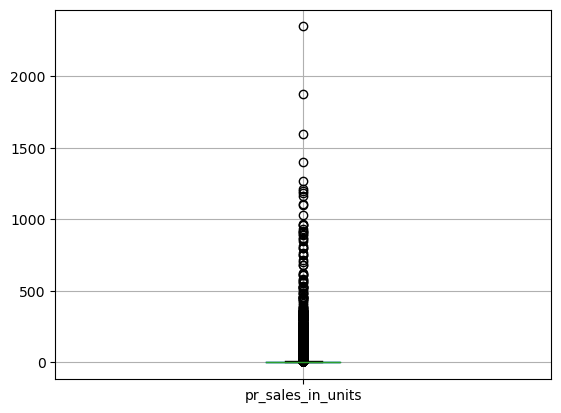

In [21]:
data.boxplot('pr_sales_in_units')

In [22]:
data[(data['pr_sales_in_units'] > 250)]

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_sales_in_rub,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id
104,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-12-31,0,261.0,48748.0,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,d29b5ce9c2883f0b7e90f79071a2ca82,1
1203,42a0e188f5033bc65bf8d78622277c4e,c7b711619071c92bef604c7ad68380dd,2022-12-31,0,297.0,42808.0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,d29b5ce9c2883f0b7e90f79071a2ca82,1
18654,16a5cdae362b8d27a1d8f8c7b78b4330,62d4af457ba2540ce0898a211c0cd17a,2022-09-16,0,254.0,4485.0,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,2,8,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,17
19151,16a5cdae362b8d27a1d8f8c7b78b4330,62d4af457ba2540ce0898a211c0cd17a,2022-12-30,0,351.0,7661.0,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,2,8,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,17
19328,f7e6c85504ce6e82442c770f7c8606f0,62d4af457ba2540ce0898a211c0cd17a,2022-12-30,0,624.0,9039.0,3202111cf90e7c816a472aaceb72b0df,32586311f16876abf92901085bd87b99,1,1,12,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
714872,42a0e188f5033bc65bf8d78622277c4e,6d6ca571e2a7d2ec70bd9c09aac38f92,2023-04-14,1,339.0,16645.0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,60787c41b04097dfea76addfccd12243,17
714921,6364d3f0f495b6ab9dcf8d3b5c6e0b01,6d6ca571e2a7d2ec70bd9c09aac38f92,2023-04-14,1,279.0,13662.0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,60787c41b04097dfea76addfccd12243,17
779401,42a0e188f5033bc65bf8d78622277c4e,8cad09283d1d6c5fb08daec8a576a72d,2022-08-08,0,345.0,169379.0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,c51ce410c124a10e0db5e4b97fc2af39,5caf41d62364d5b41a893adc1a9dd5d4,4e96157c3c8c24f4761a7bc4411a2504,1
779404,42a0e188f5033bc65bf8d78622277c4e,8cad09283d1d6c5fb08daec8a576a72d,2023-03-21,1,440.0,183265.0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,c51ce410c124a10e0db5e4b97fc2af39,5caf41d62364d5b41a893adc1a9dd5d4,4e96157c3c8c24f4761a7bc4411a2504,1


Как видим, выбросами является любая продажа больше 30-50 единиц за раз (для примера взял данные с более 500 продаж за день), но у нас есть праздничные и выходные дни, когда люди покупают больше готовой продукции, поэтому логичнее считать за выброс обычный день с всокими продажами.

Для этого возьмем датасет с праздниками:

In [23]:
holidays = pd.read_csv('holidays_covid_calendar.csv', index_col=[0], parse_dates=['date'], dayfirst=True)

In [24]:
holidays.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3653 entries, 2015 to 2024
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   day      3653 non-null   int64         
 1   weekday  3653 non-null   int64         
 2   date     3653 non-null   datetime64[ns]
 3   calday   3653 non-null   int64         
 4   holiday  3653 non-null   int64         
 5   covid    3653 non-null   int64         
dtypes: datetime64[ns](1), int64(5)
memory usage: 199.8 KB


In [25]:
holidays = holidays.drop(columns=['day', 'weekday', 'calday', 'covid'], axis = 1)

In [26]:
data['date'] = pd.to_datetime(data['date'])

In [27]:
data = data.merge(holidays, on = 'date')

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 814881 entries, 0 to 814880
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   st_id              814881 non-null  object        
 1   pr_sku_id          814881 non-null  object        
 2   date               814881 non-null  datetime64[ns]
 3   pr_sales_type_id   814881 non-null  int64         
 4   pr_sales_in_units  814881 non-null  float64       
 5   pr_sales_in_rub    814881 non-null  float64       
 6   st_city_id         814881 non-null  object        
 7   st_division_code   814881 non-null  object        
 8   st_type_format_id  814881 non-null  int64         
 9   st_type_loc_id     814881 non-null  int64         
 10  st_type_size_id    814881 non-null  int64         
 11  pr_group_id        814881 non-null  object        
 12  pr_cat_id          814881 non-null  object        
 13  pr_subcat_id       814881 non-null  object  

In [29]:
data.head()

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_sales_in_rub,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,holiday
0,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-10-20,1,5.0,825.0,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,d29b5ce9c2883f0b7e90f79071a2ca82,1,0
1,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-10-20,0,18.0,3202.0,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,d29b5ce9c2883f0b7e90f79071a2ca82,1,0
2,42a0e188f5033bc65bf8d78622277c4e,c7b711619071c92bef604c7ad68380dd,2022-10-20,1,2.0,336.0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,d29b5ce9c2883f0b7e90f79071a2ca82,1,0
3,42a0e188f5033bc65bf8d78622277c4e,c7b711619071c92bef604c7ad68380dd,2022-10-20,0,12.0,2382.0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,d29b5ce9c2883f0b7e90f79071a2ca82,1,0
4,16a5cdae362b8d27a1d8f8c7b78b4330,c7b711619071c92bef604c7ad68380dd,2022-10-20,1,1.0,129.0,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,2,8,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,d29b5ce9c2883f0b7e90f79071a2ca82,1,0


In [30]:
data.loc[data['date'] == '2022-11-04', 'holiday'] = 1
data.loc[data['date'] == '2022-12-30', 'holiday'] = 1
data.loc[data['date'] == '2022-12-29', 'holiday'] = 1
data.loc[data['date'] == '2023-02-22', 'holiday'] = 1
data.loc[data['date'] == '2023-03-07', 'holiday'] = 1
data.loc[data['date'] == '2023-04-14', 'holiday'] = 1

Сменим индекс нашего датасета на дату покупки и приведем ее в нужный формат:

In [31]:
data = data.set_index('date')

Отсортируем по возрастанию даты:

In [32]:
data = data.sort_index(ascending=True)

<Axes: >

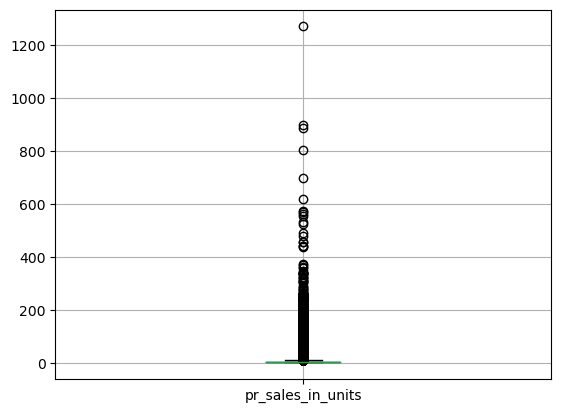

In [33]:
data[(data['holiday'] != 1)].boxplot('pr_sales_in_units')

In [34]:
data.describe()

,pr_sales_type_id,pr_sales_in_units,pr_sales_in_rub,st_type_format_id,st_type_loc_id,st_type_size_id,pr_uom_id,holiday
count,814881.000000,814881.000000,814881.000000,814881.000000,814881.000000,814881.000000,814881.000000,814881.000000
mean,0.400998,5.452354,640.105715,1.099091,1.204884,11.501705,7.204567,0.355303
std,0.490101,13.869236,1634.419367,0.417325,0.437268,4.601198,7.795928,0.478605
min,0.000000,1.000000,1.000000,1.000000,1.000000,8.000000,1.000000,0.000000
25%,0.000000,1.000000,116.000000,1.000000,1.000000,8.000000,1.000000,0.000000
50%,0.000000,2.000000,251.000000,1.000000,1.000000,12.000000,1.000000,0.000000
75%,1.000000,5.000000,588.000000,1.000000,1.000000,12.000000,17.000000,1.000000
max,1.000000,2348.000000,183265.000000,4.000000,3.000000,28.000000,17.000000,1.000000


In [35]:
#pd.set_option('display.max_rows', None)

In [36]:
data[(data['pr_sales_in_units'] > 20) & (data['holiday'] != 1)].shape

(19374, 15)

Осталось всего 19374 строки с продажами выше 20 шт в день, совершенных не в предпраздничные и приаздничные дни

In [37]:
#data['dayofweek'] = data.index.dayofweek

In [38]:
#data['month'] = data.index.month

In [39]:
from tsfresh import select_features, extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import EfficientFCParameters
from tsfresh.feature_extraction.settings import from_columns
from tsfresh.feature_extraction import settings

In [40]:
settings_minimal = settings.MinimalFCParameters()
settings_minimal

{'sum_values': None, 'median': None, 'mean': None, 'length': None, 'standard_deviation': None, 'variance': None, 'root_mean_square': None, 'maximum': None, 'absolute_maximum': None, 'minimum': None}

In [41]:
#settings_time = settings.TimeBasedFCParameters()
#settings_time.update(settings_minimal)
#settings_time

In [42]:
#settings_efficient = settings.EfficientFCParameters()
#settings_efficient

In [43]:
#settings_comprehensive = settings.ComprehensiveFCParameters()
#len(settings_comprehensive)

In [44]:
sales_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883015 entries, 0 to 883014
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   st_id              883015 non-null  object 
 1   pr_sku_id          883015 non-null  object 
 2   date               883015 non-null  object 
 3   pr_sales_type_id   883015 non-null  int64  
 4   pr_sales_in_units  883015 non-null  float64
 5   pr_sales_in_rub    883015 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 40.4+ MB


In [45]:
from sklearn.preprocessing import OrdinalEncoder

ord_enc = OrdinalEncoder()

In [46]:
sales_df_train_new = sales_df_train.loc[:2000]

In [47]:
sales_df_train_new.shape

(2001, 6)

In [48]:
sales_df_train_new["st_id"] = ord_enc.fit_transform(sales_df_train_new[["st_id"]])

In [49]:
sales_df_train_new["pr_sku_id"] = ord_enc.fit_transform(sales_df_train_new[["pr_sku_id"]])

In [50]:
extracted_features = extract_features(sales_df_train_new, column_id='st_id', 
                                      column_kind=None, column_value="pr_sales_in_units", 
                                      column_sort="date", impute_function=impute)

Feature Extraction: 100%|███████████████████████| 10/10 [00:01<00:00,  6.06it/s]


In [51]:
extracted_features

,pr_sales_in_units__variance_larger_than_standard_deviation,pr_sales_in_units__has_duplicate_max,pr_sales_in_units__has_duplicate_min,pr_sales_in_units__has_duplicate,pr_sales_in_units__sum_values,pr_sales_in_units__abs_energy,pr_sales_in_units__mean_abs_change,pr_sales_in_units__mean_change,pr_sales_in_units__mean_second_derivative_central,pr_sales_in_units__median,...,pr_sales_in_units__fourier_entropy__bins_5,pr_sales_in_units__fourier_entropy__bins_10,pr_sales_in_units__fourier_entropy__bins_100,pr_sales_in_units__permutation_entropy__dimension_3__tau_1,pr_sales_in_units__permutation_entropy__dimension_4__tau_1,pr_sales_in_units__permutation_entropy__dimension_5__tau_1,pr_sales_in_units__permutation_entropy__dimension_6__tau_1,pr_sales_in_units__permutation_entropy__dimension_7__tau_1,pr_sales_in_units__query_similarity_count__query_None__threshold_0.0,pr_sales_in_units__mean_n_absolute_max__number_of_maxima_7
0.0,1.0,0.0,1.0,1.0,2000.0,52084.0,7.402899,0.034783,0.000000,2.0,...,0.969357,1.645240,3.663904,1.773026,3.120933,4.553245,5.489235,5.759631,0.0,64.428571
1.0,0.0,1.0,1.0,1.0,4.0,8.0,0.000000,0.000000,0.007911,2.0,...,1.098612,1.682689,3.626381,1.731430,3.020809,4.362015,5.201796,5.495600,0.0,44.928571
2.0,1.0,0.0,1.0,1.0,406.0,2492.0,2.726562,0.007812,-0.011811,2.0,...,1.142419,1.726613,3.404047,1.699637,2.890302,4.024852,4.606386,4.767102,0.0,12.857143
3.0,1.0,0.0,1.0,1.0,1582.0,68470.0,6.220820,-0.006309,0.007911,2.0,...,1.343792,2.014465,3.848065,1.737610,3.039076,4.429032,5.355552,5.641898,0.0,79.285714
4.0,1.0,0.0,0.0,1.0,23.0,53.0,1.384615,0.153846,0.083333,1.0,...,0.900256,1.213008,1.667462,1.517106,2.271869,2.302585,2.197225,2.079442,0.0,2.428571
5.0,1.0,0.0,1.0,1.0,992.0,13744.0,4.226721,0.000000,0.030488,2.0,...,1.135681,1.775458,3.714376,1.729887,3.007557,4.328063,5.101060,5.377934,0.0,31.714286
6.0,1.0,0.0,0.0,1.0,9.0,25.0,1.666667,0.333333,-0.750000,2.0,...,1.098612,1.098612,1.098612,0.693147,-0.000000,4.362015,5.201796,5.495600,0.0,44.928571
7.0,1.0,0.0,1.0,1.0,2203.0,41517.0,6.845361,-0.046392,0.025840,3.0,...,1.363726,2.009366,3.918922,1.754332,3.075181,4.497451,5.473388,5.837346,0.0,48.142857
8.0,1.0,0.0,1.0,1.0,1360.0,30286.0,5.975610,0.003484,-0.001748,2.0,...,0.815017,1.480712,3.498373,1.746668,3.048847,4.395966,5.275865,5.546649,0.0,47.714286
9.0,1.0,0.0,1.0,1.0,1032.0,19698.0,4.809160,-0.022901,0.015326,2.0,...,1.046217,1.682689,3.626381,1.731430,3.020809,4.284067,5.127727,5.444551,0.0,42.142857


In [53]:
pip install featuretools

Note: you may need to restart the kernel to use updated packages.


In [54]:
import featuretools as ft

In [55]:
#ft.primitives.list_primitives()

In [55]:
dataframes = {
    "pr_df": (pr_df, "pr_sku_id"),
    "sales_df_train": (sales_df_train, "st_id", "pr_sku_id", "date"),
    "sf_df": (sf_df, "st_id"),
}

In [56]:
relationships = [
    ("pr_df", "pr_sku_id", "sales_df_train", "pr_sku_id"),
    ("sales_df_train", "st_id", "sf_df", "st_id"),
]

In [57]:
feature_matrix_customers, features_defs = ft.dfs(
    dataframes=dataframes,
    relationships=relationships,
    target_dataframe_name="sales_df_train",
)
feature_matrix_customers

AttributeError: 'str' object has no attribute 'keys'

In [86]:
feature_matrix_sessions, features_defs = ft.dfs( dataframes=dataframes, 
                                                relationships=relationships, target_dataframe_name="sf_df"
                                               )
feature_matrix_sessions.head(5)

AttributeError: 'str' object has no attribute 'keys'

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

def timeseriesCVscore(x):
    # вектор ошибок
    errors = []

    values = data.values
    alpha, beta, gamma = x

    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=3) 

    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen = 24*7, alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()

        predictions = model.result[-len(test):]
        actual = values[test]
        error = mean_squared_error(predictions, actual)
        errors.append(error)

    # Возвращаем средний квадрат ошибки по вектору ошибок 
    return np.mean(np.array(errors))


#Значение длины сезона 24*7 возникло не случайно — в исходном ряде отчетливо видна дневная сезонность, 
#(отсюда 24), и недельная — по будням ниже, на выходных — выше, (отсюда 7), суммарно сезонных компонент 
#получится 24*7.